In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import nltk
import gensim
from gensim import corpora, models
import string
from nltk.stem import WordNetLemmatizer 
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database, drop_database
import matplotlib.pyplot as plt

In [ ]:
retrain = False

In [2]:
sns.set_style('whitegrid')

small_size = 18
medium_size = 20
bigger_size = 22

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

In [3]:
with open('pg_credentials.p', 'rb') as f:
    pg_credentials = pickle.load(f)

In [4]:
host     = 'localhost'
db_name  = 'goodreads_db'
username = pg_credentials['username']
password = pg_credentials['password']
port = '5432'  # default port that postgres listens on
    
con = psycopg2.connect(database = db_name, user = username, host=host, password=password)

In [6]:
query = "SELECT reviews, title, author, true_score AS winner_frac FROM works_withgenre"
review_data = pd.read_sql_query(query, con)

In [8]:
import itertools
lemmatizer = WordNetLemmatizer() 

stopwords = (nltk.corpus.stopwords.words('english')
             + ['book', 'read'])

# First, get rid of proper nouns, as this is contaminating our topic modeling!
def remove_proper_nouns(review):
    tokens = review.split()
    review = ' '.join([t for t in tokens if t[:4].lower()!="http"])
    sentences = review.split('.')
    sentences = [s.split() for s in sentences]
    sentences = [' '.join([w for i, w in enumerate(words) if i==0 or w[0]==w[0].lower()]) for words in sentences]
    sentences = [s.lower() for s in sentences]
    return sentences

reviews = []
for review in review_data['reviews']:
    reviews.extend(remove_proper_nouns(review))
reviews_lemmatized = [[lemmatizer.lemmatize(t) 
                       for t in nltk.word_tokenize(review)] 
                      for review in reviews if review]
clean_reviews = [[r for r in review if r not in stopwords and len(r)>3] for review in reviews_lemmatized]

In [40]:
if retrain:
    dictionary = gensim.corpora.Dictionary(clean_reviews)
    dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in clean_reviews]
    dictionary.save('dictionary.gensim')
else:
    dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [41]:
if retrain:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
    lda_model.save('good_lda_model.gensim')
else:
    lda_model = gensim.models.LdaMulticore.load('good_lda_model.gensim')

In [15]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.048*"series" + 0.047*"much" + 0.043*"love" + 0.035*"first" + 0.026*"really" + 0.016*"story" + 0.015*"loved" + 0.014*"reading" + 0.013*"liked" + 0.013*"enjoyed"
Topic: 1 
Words: 0.018*"life" + 0.013*"fiction" + 0.013*"science" + 0.011*"world" + 0.011*"need" + 0.010*"woman" + 0.009*"fantasy" + 0.009*"people" + 0.008*"question" + 0.008*"child"
Topic: 2 
Words: 0.067*"character" + 0.049*"story" + 0.021*"plot" + 0.020*"great" + 0.016*"interesting" + 0.015*"well" + 0.013*"world" + 0.012*"writing" + 0.011*"main" + 0.011*"action"
Topic: 3 
Words: 0.029*"page" + 0.026*"story" + 0.018*"novel" + 0.018*"favorite" + 0.015*"last" + 0.014*"first" + 0.014*"short" + 0.012*"beginning" + 0.010*"chapter" + 0.010*"maybe"
Topic: 4 
Words: 0.041*"thing" + 0.020*"make" + 0.019*"think" + 0.018*"good" + 0.018*"like" + 0.014*"many" + 0.014*"even" + 0.013*"time" + 0.012*"best" + 0.012*"people"
Topic: 5 
Words: 0.066*"like" + 0.047*"would" + 0.028*"know" + 0.027*"feel" + 0.020*"want" + 0.020*"st

In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [23]:
def make_nvec(v, n=10):
    if len(v)==10:
        return [vv[1] for vv in v]
    result = [0.]*10
    for vv in v:
        result[vv[0]] = vv[1]
    return result

sentiments = []
nsentiments = []
vectors = []
for review in review_data['reviews']:
    sentences = []
    for sentence in review.split('.'):
        sentences.extend(sentence.split('||'))

    clean_sentences = [remove_proper_nouns(sentence)[0] for sentence in sentences]
    clean_sentences = [[lemmatizer.lemmatize(t) for t in nltk.word_tokenize(sentence)]
                       for sentence in clean_sentences]
    clean_sentences = [[word for word in sentence if word not in stopwords and len(word)>3]
                       for sentence in clean_sentences]
    clean_sentences = [dictionary.doc2bow(sentence) for sentence in clean_sentences]
    sentence_vectors = [make_nvec(lda_model[sentence]) for sentence in clean_sentences]
    vectors.append(np.mean(sentence_vectors, axis=0))
    
    sentiment = np.zeros(10)
    nsentiment = np.zeros(10)
    for sentence, vector in zip(sentences, sentence_vectors):
        score = sid.polarity_scores(sentence)
        sentiment[np.argmax(vector)] += score['compound']
        nsentiment[np.argmax(vector)] += 1
    sentiments.append(sentiment/nsentiment)
    nsentiments.append(nsentiment)

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [25]:
sentiments = np.array(sentiments)
sentiments[np.isnan(sentiments)] = 0 #division by zero

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate=300,perplexity = 30,early_exaggeration = 12,init = 'random',  random_state=2019)
X_tsne = tsne.fit_transform(sentiments)
print(X_tsne.shape)

(4830, 2)


In [27]:
labels = np.array([np.argmax(s) for s in sentiments])
masks = []
for i in range(10):
    masks.append(labels==i)

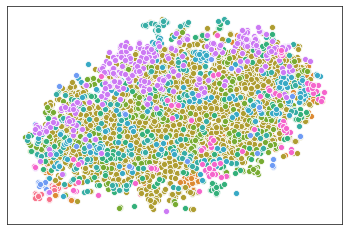

In [28]:
sns.set_style("white")
with sns.color_palette("husl", 10):
    for i in range(10):
        sns.scatterplot(X_tsne[masks[i],0], X_tsne[masks[i],1])
    plt.yticks([], [])
    plt.xticks([], [])

In [29]:
query = ("SELECT * FROM works_withgenre")
all_data = pd.read_sql_query(query, con)

for i in range(10):
    all_data['review_embed{}'.format(i)] = sentiments[:,i]


In [30]:
all_data = all_data.drop(columns=["reviews"])

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name))
all_data.to_sql('works_withgenrelang', engine) 